In [86]:
import json
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.sandbox.regression.predstd import wls_prediction_std
import sys
import statsmodels.formula.api as smf
import pandas
import sklearn.datasets as sk_data
import sklearn.metrics as metrics
from sklearn.cluster import KMeans
import pandas as pd
from recsys.algorithm.factorize import SVD

import warnings
from sklearn.ensemble.forest import DecisionTreeRegressor as tree
import json

from collections import Counter
import random

import seaborn as sns
%matplotlib inline


    parsing one again

In [127]:

with open('../boston-rows.json') as data_file:    
    bostonjson = json.load(data_file)

print len(bostonjson['data'])

columnlist = []
for col in bostonjson['meta']['view']['columns']:
    columnlist.append(col['name'])

bostondf = pd.DataFrame(bostonjson['data'])
bostondf.columns = columnlist
print columnlist
print bostondf.head()[['INCIDENT_TYPE_DESCRIPTION','FROMDATE','Location']]

#latlist = map(lambda k: k[1], bostondf['Location'])
#longlist = map(lambda k: k[2], bostondf['Location'])

types = map(lambda k: k.lower(), bostondf['INCIDENT_TYPE_DESCRIPTION'])
hours = map(lambda k: k.split("T")[1].split(":")[0], bostondf['FROMDATE'])
days = map(lambda k: k, bostondf['DAY_WEEK'])
distrs = map(lambda k: k, bostondf['REPTDISTRICT'])
print len(hours), len(list(set(distrs)))

hourlist = []
daylist = []
distrlist = []
typelist = []

#print types[0], hours[0], days[0], distrs[10000]
print len(hours), len(types), len(distrs)
for i in xrange(len(hours)):
    
    if types[i] != 'val' and distrs[i] and distrs[i] != 'NULL':
        hourlist.append(hours[i])
        daylist.append(days[i] )
        distrlist.append(distrs[i])
        typelist.append(types[i])

typeCnt = Counter(typelist)
print len(typeCnt)


268056
[u'sid', u'id', u'position', u'created_at', u'created_meta', u'updated_at', u'updated_meta', u'meta', u'COMPNOS', u'NatureCode', u'INCIDENT_TYPE_DESCRIPTION', u'MAIN_CRIMECODE', u'REPTDISTRICT', u'REPORTINGAREA', u'FROMDATE', u'WEAPONTYPE', u'Shooting', u'DOMESTIC', u'SHIFT', u'Year', u'Month', u'DAY_WEEK', u'UCRPART', u'X', u'Y', u'STREETNAME', u'XSTREETNAME', u'Location']
  INCIDENT_TYPE_DESCRIPTION             FROMDATE  \
0      RESIDENTIAL BURGLARY  2012-07-08T06:00:00   
1        AGGRAVATED ASSAULT  2012-07-08T06:03:00   
2                   ROBBERY  2012-07-08T06:26:00   
3       COMMERCIAL BURGLARY  2012-07-08T06:56:00   
4                   ROBBERY  2012-07-08T07:15:00   

                                         Location  
0  [None, 42.34638135, -71.10379454, None, False]  
1  [None, 42.31684135, -71.07458456, None, False]  
2  [None, 42.34284135, -71.09698955, None, False]  
3   [None, 42.3164411, -71.06582908, None, False]  
4  [None, 42.27051636, -71.11989955, None, 

### BUILD TREE AND TRAIN

#### 1. Type of Crime

In [29]:

daydict = {"monday":1, "tuesday":2, "wednesday":3, "thursday":4, "friday":5, "saturday":6, "sunday":7}

typeX = []
typey = []

inTypefd = open("../data/Boston-parse-type.dat.input","r")
for l in inTypefd.readlines():
    row = l.split("::")
    typeX.append([hash(row[0]),daydict[row[1].lower()]])
    typey.append(row[2][:-1])
inTypefd.close()

timeX = []
timey = []

inTimefd = open("../data/Boston-parse-time.dat.input","r")
for l in inTimefd.readlines():
    row = l.split("::")
    timeX.append([hash(row[0]),daydict[row[1].lower()]])
    timey.append(row[2][:-1])
inTimefd.close()

In [7]:
trainTypeSet = []

trainTypefd = open("../data/Boston-parse-type.dat.trainerr","r")
for l in trainTypefd.readlines():
    row = l.split("::")
    trainTypeSet.append(row)
trainTypefd.close()
print trainTypeSet[0]

['A1', 'Sunday', '41\n']


In [8]:

warnings.filterwarnings("ignore", category=DeprecationWarning) 


glerr = float('inf')
optLeaftype, optDepthtype = None, None
rate = 0.0

for leaf in xrange(22, 30):
    print 'leaf', leaf, optLeaftype, rate,":",
    """
    Predict with each model and find minimum error parameters
    """
    for depth in range(5, 16, 2):
        model = tree(min_samples_leaf=leaf, max_depth=depth)
        model = model.fit(typeX,typey)

        err = 0.0
        crCount = 0
        for l in trainTypeSet:            
            #print l
            x = [hash(l[0]),daydict[l[1].lower()]]
            
            pred = model.predict(x)[0]
            #print pred, l[2][:-1]
            #sys.exit(0)
            err += (pred-int(l[2][:-1]))**2
            crCount +=1
            
        rate = 1.0*err/10000
        if rate < glerr:
            glerr = rate
            """
            Later use these to build predicting model:
            """
            optLeaftype, optDepthtype  = leaf, depth
        
    print (glerr/crCount)**0.5

leaf 22 None 0.0 : 0.368219286321
leaf 23 22 8470.05177712 : 0.368219286321
leaf 24 22 8470.05177712 : 0.368219286321
leaf 25 22 8470.05177712 : 0.368219286321
leaf 26 22 8470.05177712 : 0.368219286321
leaf 27 22 8470.05177712 : 0.368219286321
leaf 28 22 8470.05177712 : 0.368219286321
leaf 29 22 8470.05177712 : 0.368219286321


In [9]:
print optLeaftype, optDepthtype

22 7


#### 2. Time of crime

In [10]:
trainTimeSet = []

trainTimefd = open("../data/Boston-parse-time.dat.trainerr","r")
for l in trainTimefd.readlines():
    row = l.split("::")
    trainTimeSet.append(row)
trainTimefd.close()
print trainTimeSet[0]

['A1', 'Sunday', '2\n']


In [15]:

warnings.filterwarnings("ignore", category=DeprecationWarning) 


glerr = float('inf')
optLeaftime, optDepthtime = None, None
rate = 0.0


for leaf in xrange(20, 30):
    print 'leaf', leaf, optLeaftime, rate,":",
    """
    Predict with each model and find minimum error parameters
    """
    for depth in range(5, 16, 2):
        model = tree(min_samples_leaf=leaf, max_depth=depth)
        model = model.fit(timeX,timey)

        err = 0
        nCount = 0
        for l in trainTimeSet:                        
            x = [hash(l[0]),daydict[l[1].lower()]]
            
            pred = round(model.predict(x)[0])
            #print pred, l[2][:-1]
            #sys.exit(0)
            err += (pred-int(l[2][:-1]))**2
            nCount += 1
        rate = 1.0*err/10000
        if rate < glerr:
            glerr = rate
            """
            Later use these to build predicting model:
            """
            optLeaftime, optDepthtime  = leaf, depth
        
    print (glerr/nCount)**0.5

 leaf 20 None 0.0 : 0.00845426156186
leaf 21 20 4.4648 : 0.00845426156186
leaf 22 20 4.4648 : 0.00845426156186
leaf 23 20 4.4648 : 0.00845426156186
leaf 24 20 4.4648 : 0.00845426156186
leaf 25 20 4.4648 : 0.00845426156186
leaf 26 20 4.4648 : 0.00845426156186
leaf 27 20 4.4648 : 0.00845426156186
leaf 28 20 4.4648 : 0.00845426156186
leaf 29 20 4.4648 : 0.00845426156186


In [16]:
print optLeaftime, optDepthtime

20 5


### PREDICT USING NAIVE BAYES CLASSIFIER

In [141]:
import pandas as pd
from sklearn.cross_validation import train_test_split
from sklearn import preprocessing
from sklearn.metrics import log_loss
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
import numpy as np

#Get binarized weekdays, districts, and hours.
days = pd.get_dummies(daylist)
district = pd.get_dummies(distrlist)
hour = pd.get_dummies(hourlist) 
 
#Build new array
train_data = pd.concat([hour, days, district], axis=1)
train_data['crime']=typelist

colList = list(set(hour))+list(set(days))+list(set(district))
print colList
print train_data.head()

[u'22', u'02', u'03', u'00', u'01', u'06', u'07', u'04', u'05', u'08', u'09', u'20', u'21', u'11', u'10', u'13', u'12', u'15', u'14', u'17', u'16', u'19', u'18', u'23', u'Monday', u'Tuesday', u'Friday', u'Wednesday', u'Thursday', u'Sunday', u'Saturday', u'A15', u'D14', u'A7', u'E18', u'E13', u'A1', u'D4', u'HTU', u'B2', u'B3', u'E5', u'C11', u'C6']
   00  01  02  03  04  05  06  07  08  09          ...           B3  C11  C6  \
0   0   0   0   0   0   0   1   0   0   0          ...            0    0   0   
1   0   0   0   0   0   0   1   0   0   0          ...            0    0   0   
2   0   0   0   0   0   0   1   0   0   0          ...            0    0   0   
3   0   0   0   0   0   0   1   0   0   0          ...            0    0   0   
4   0   0   0   0   0   0   0   1   0   0          ...            0    0   0   

   D14  D4  E13  E18  E5  HTU                 crime  
0    0   1    0    0   0    0  residential burglary  
1    0   0    0    0   0    0    aggravated assault  
2    0

In [142]:
from collections import defaultdict
#Repeat for test data
Btest = defaultdict(list)
testTypefd = open("../data/Boston.dat.testpair","r")
for l in testTypefd.readlines():
    row = l.split("::")
    Btest['District'].append(row[0])
    Btest['DayOfWeek'].append(row[1])
    Btest['Hour'].append(row[2][:-1])

    
testTypefd.close()

days = pd.get_dummies(Btest['DayOfWeek'])
district = pd.get_dummies(Btest['District'])
hour = pd.get_dummies(Btest['Hour']) 

test_data = pd.concat([hour, days, district], axis=1)

training, validation = train_test_split(train_data, train_size=.60)

commonCrimes = map(lambda k: k[0].lower(), typeCnt.most_common(20))

features = ['Friday', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday',
 'Wednesday']+list(set(district))
print features, len(features)
training, validation = train_test_split(train_data, train_size=.60)
print training.head()
model = BernoulliNB()
model.fit(training[features], training['crime'])


['Friday', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'A15', 'D14', 'A7', 'E18', 'E13', 'A1', 'D4', 'HTU', 'B2', 'B3', 'E5', 'C11', 'C6'] 20
        00  01  02  03  04  05  06  07  08  09             ...              \
163206   0   0   0   0   0   0   0   0   0   0             ...               
217067   0   0   0   0   0   0   0   0   0   0             ...               
177201   0   0   0   0   0   0   0   0   0   0             ...               
193071   0   0   0   0   0   0   0   0   0   0             ...               
187624   0   0   0   0   0   0   0   0   0   0             ...               

        B3  C11  C6  D14  D4  E13  E18  E5  HTU                       crime  
163206   0    0   0    0   1    0    0   0    0              weapons charge  
217067   0    0   0    1   0    0    0   0    0                     invprop  
177201   0    0   0    0   0    0    0   0    0                     invprop  
193071   0    0   0    0   0    0    0   0    0      

BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)

In [143]:
#predicted = np.array(model.predict_proba(validation[features]))
predicted = np.array(model.predict(validation[features]))
print type(predicted)
print predicted[0:50]
#log_loss(validation['crime'], predicted) 

"""
#Logistic Regression for comparison
model = LogisticRegression(C=.01)
model.fit(training[features], training['crime'])
predicted = np.array(model.predict_proba(validation[features]))
#log_loss(validation['crime'], predicted) 
print predicted[0:50]

"""
print "Done"


<type 'numpy.ndarray'>
[u'other larceny' u'other larceny' u'other larceny' u'simple assault'
 u'simple assault' u'other larceny' u'vandalism' u'other larceny'
 u'other larceny' u'medassist' u'other larceny' u'vandalism'
 u'simple assault' u'simple assault' u'simple assault' u'other larceny'
 u'medassist' u'medassist' u'simple assault' u'simple assault'
 u'simple assault' u'other larceny' u'simple assault' u'simple assault'
 u'towed' u'simple assault' u'simple assault' u'medassist' u'medassist'
 u'other larceny' u'simple assault' u'other larceny' u'other larceny'
 u'medassist' u'medassist' u'medassist' u'vandalism' u'medassist'
 u'medassist' u'medassist' u'simple assault' u'other larceny' u'medassist'
 u'other larceny' u'other larceny' u'medassist' u'medassist'
 u'simple assault' u'other larceny' u'other larceny']
Done


In [147]:
newmodel = BernoulliNB()
newmodel.fit(train_data[features], train_data['crime'])
predicted = newmodel.predict(test_data[features])
print predicted[:50]

#Write results
#result=pd.DataFrame(predicted)
#result.to_csv('testResult.csv', index = True, index_label = 'Id' )

[u'vandalism' u'medassist' u'other larceny' u'other larceny'
 u'other larceny' u'medassist' u'other larceny' u'vandalism'
 u'other larceny' u'simple assault' u'other larceny' u'medassist'
 u'other larceny' u'medassist' u'other larceny' u'towed' u'medassist'
 u'other larceny' u'medassist' u'other larceny' u'simple assault'
 u'simple assault' u'other larceny' u'medassist' u'medassist' u'medassist'
 u'medassist' u'other larceny' u'other larceny' u'medassist'
 u'other larceny' u'simple assault' u'other larceny' u'medassist'
 u'medassist' u'medassist' u'medassist' u'medassist' u'medassist'
 u'medassist' u'other larceny' u'other larceny' u'other larceny'
 u'other larceny' u'medassist' u'other larceny' u'other larceny'
 u'simple assault' u'other larceny' u'other larceny']


In [159]:

typePred = open("../results/NB-Boston-type-pred.dat","w")
typeTestfd = open("../data/Boston.dat.testpair","r")

for i,l in enumerate(typeTestfd.readlines()):
    row = l.split("::")    
    typePred.write(row[0]+"-"+row[1][:-1]+","+predicted[i]+"\n")
    #print (row[0]+"-"+row[1]+","+predicted[i]+"\n")
    #break

typeTestfd.close()
typePred.close()

### PREDICTION ANALYSIS

Counter({u'other larceny': 5401, u'medassist': 5122, u'simple assault': 4097, u'vandalism': 636, u'drug charges': 356, u'mvacc': 228, u'towed': 150, u'larceny from motor vehicle': 41, u'prostitution charges': 1})
['D14', 'Sunday', '10', u'vandalism']
Counter({u'simple assault': 256})


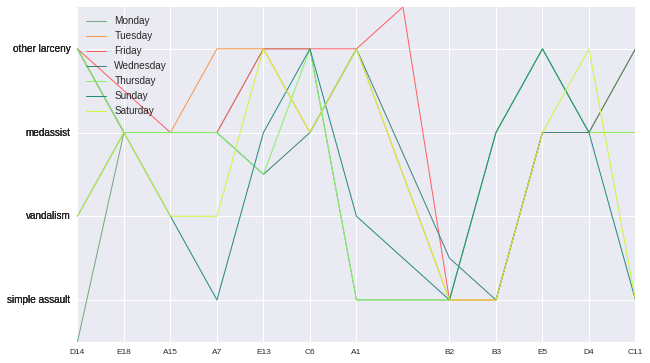

In [262]:
print Counter(predicted)
print bostonAnalysis[0]

crTypes = Counter(predicted).keys()
distNames = list(set(distrlist))

bostonanalysisdict1 = defaultdict(dict)
bostonanalysisdict2 = defaultdict(dict)

for l in bostonAnalysis:
    try:
        bostonanalysisdict1[l[1]][l[0]] += [l[3]]
        bostonanalysisdict2[l[1]][l[2]] += [l[3]]
    except KeyError:
        bostonanalysisdict1[l[1]][l[0]] = [l[3]]
        bostonanalysisdict2[l[1]][l[2]] = [l[3]]
        

    
print Counter(bostonanalysisdict1['Sunday']['C11'])
#print bostonanalysisdict2['Sunday'].keys()
plt.figure(figsize=(10, 6), dpi=80)
for day, vallist in bostonanalysisdict1.iteritems():
    Yax = []
    Xax = []
    for dist,vl in vallist.iteritems():
        #print day, dist, Counter(vl).most_common(1)[0][0]
        
        Yax += [crTypes.index(Counter(vl).most_common(1)[0][0])]
        Xax += [distNames.index(dist)]

    #print Yax, Xax

    plt.plot(sorted(Xax), Yax, color=(random.uniform(0,1),random.uniform(0,1),random.uniform(0,0.5)), linewidth=1.0, linestyle="-", label=day)
    plt.xticks(Xax, [distNames[i] for i in Xax], size='small')
    plt.yticks(Yax, [crTypes[i] for i in Yax], size='medium')
    plt.legend(loc='upper left')
plt.show()
    
#per day, per district, what is most likely crime type



[5, 7, 7, 5, 5, 7, 5, 7, 5, 5, 5, 5, 1, 5, 5, 5, 5, 5, 5, 5, 1, 1, 5, 5] [22, 2, 3, 0, 1, 6, 7, 4, 5, 8, 9, 20, 21, 11, 10, 13, 12, 15, 14, 17, 16, 19, 18, 23]


IndexError: list index out of range

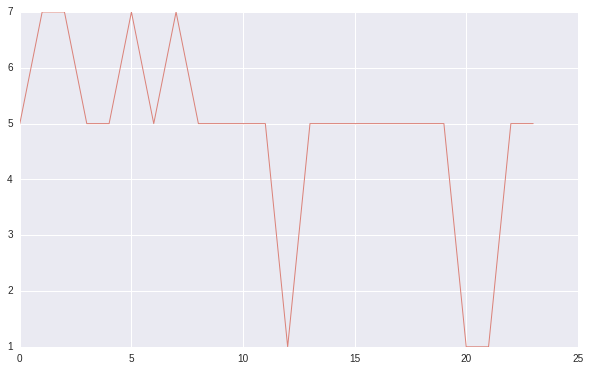

In [264]:

plt.figure(figsize=(10, 6), dpi=80)
for day, vallist in bostonanalysisdict2.iteritems():
    Yax = []
    Xax = []
    for hour,vl in vallist.iteritems():
        #print day, dist, Counter(vl).most_common(1)[0][0]
        
        Yax += [crTypes.index(Counter(vl).most_common(1)[0][0])]
        Xax += [int(hour)]

    print Yax, Xax

    plt.plot(sorted(Xax), Yax, color=(random.uniform(0,1),random.uniform(0,1),random.uniform(0,0.5)), linewidth=1.0, linestyle="-", label=day)
    plt.xticks(Xax, [distNames[i] for i in Xax], size='small')
    plt.yticks(Yax, [crTypes[i] for i in Yax], size='medium')
    plt.legend(loc='upper left')
plt.show()


### PREDICT USING TREES

#### 1. Type of Crime

In [35]:
model = tree(min_samples_leaf=optLeaftype, max_depth=optDepthtype)
model = model.fit(typeX,typey)

testTypefd = open("../data/Boston.dat.testpair","r")
resfd = open("../results/Boston-type-pred.dat","w")
for l in testTypefd.readlines():
    row = l.split("::")
    
    x = [hash(row[0]),daydict[row[1][:-1].lower()]]
    pred = int(round(model.predict(x)[0]))
    #resfd.write(row[0]+"-"+row[1][:-1]+"-"+str(pred)+"\n")
    resfd.write(row[0]+"-"+row[1][:-1]+"-"+list(typeCnt.keys())[pred]+"\n")
    #print list(typeCnt.keys())[pred]
    #print pred
    #break
    
testTypefd.close()
resfd.close()

#### 2. Time of the day

In [138]:
model = tree(min_samples_leaf=optLeaftime, max_depth=optDepthtime)
model = model.fit(timeX,timey)

testTypefd = open("../data/Boston.dat.testpair","r")
resfd = open("../results/Boston-time-pred.dat","w")

for l in testTypefd.readlines():
    row = l.split("::")
    
    x = [hash(row[0]),daydict[row[1][:-1].lower()]]
    pred = model.predict(x)[0]*6
    resfd.write(row[0]+"-"+row[1][:-1]+"-"+str(pred)+"\n")
    #print pred
    #break
testTypefd.close()
resfd.close()

### BUILD MODEL AND TRAIN

In [37]:
svdK = 20
modelCrime = SVD()
modelCrime.load_data(filename='../data/Boston-parse-type.dat.input', sep='::', format={'col':0, 'row':1, 'value':2, 'ids': str})
modelCrime.compute(k=svdK, min_values=6, pre_normalize=None, mean_center=True, post_normalize=True)

In [70]:
trainTypefd = open("../data/Boston-parse-type.dat.trainerr","r")
for l in trainTypefd.readlines():
    row = l.split("::")
    try:        
        predTime = int(round(modelCrime.predict(row[1], row[0])%125))
        print row, predTime
        break
    except KeyError:
        print '.',
        continue

trainTypefd.close()

['A1', 'Sunday', '41\n'] 32


In [40]:
modelCrimeTime = SVD()
modelCrimeTime.load_data(filename='../data/Boston-parse-time.dat.input', sep='::', format={'col':0, 'row':1, 'value':2, 'ids': str})
modelCrimeTime.compute(k=svdK, min_values=6, pre_normalize=None, mean_center=True, post_normalize=True)

In [73]:
#../data/Boston-parse-time.dat.trainerr
trainTimefd = open("../data/Boston-parse-time.dat.trainerr","r")
for l in trainTimefd.readlines():
    row = l.split("::")
    try:
        predTime = str(round(modelCrimeTime.predict(row[1], row[0])%7))
        print row, predTime
        
        break
    except KeyError:
        print '.',
        continue


trainTimefd.close()


['A1', 'Sunday', '2\n'] 1.0


### GENERATE PREDICTION PAIRS

    Done during parsing phase

### PREDICTION

In [140]:
#../data/Boston-parse-time.dat.test
#D4:Sunday
#C6:Sunday
#E5:Sunday...
timePred = open("../results/recsys-Boston-time-pred.dat","w")
testTimefd = open("../data/Boston.dat.testpair","r")
for l in testTimefd.readlines():
    row = l.split("::")
    try:        
        predTime = str(modelCrimeTime.predict(row[1][:-1], row[0])%7)
        timePred.write(row[0]+"-"+row[1][:-1]+","+predTime+"\n")      
        #break
    except KeyError:
        #print row, '....',
        continue


testTimefd.close()
timePred.close()

In [42]:

typePred = open("../results/recsys-Boston-type-pred.dat","w")
typeTestfd = open("../data/Boston.dat.testpair","r")

for l in typeTestfd.readlines():
    row = l.split("::")
    try:        
        predType = modelCrime.predict(row[1][:-1], row[0])%100
        #print predType,
        
        #typePred.write(row[0]+"-"+row[1][:-1]+","+str(predType)+"\n") 
        typePred.write(row[0]+"-"+row[1][:-1]+"-"+list(typeCnt.keys())[int(predType)]+"\n")
        
    except KeyError:
        #print row, '....',
        continue


typeTestfd.close()
typePred.close()

### ANALYSE PREDICTIONS (Error)

In [21]:
#rmse/classiff error?...